# JAK2 activity optimization with ReLeaSE algorithm

In this experiment we will optimized parameters of pretrained generative RNN to produce molecules with maximized and minimized pIC50 for JAK2. We use policy gradient algorithm with custom reward function to bias the properties of generated molecules aka Reinforcement Learninf for Structural Evolution (ReLeaSE) as was proposed in **Popova, M., Isayev, O., & Tropsha, A. (2018). *Deep reinforcement learning for de novo drug design*. Science advances, 4(7), eaap7885.** 

## Imports

In [4]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys

In [7]:
sys.path.append('./release/')

In [8]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [9]:
use_cuda = torch.cuda.is_available()

In [10]:
use_cuda

True

In [11]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils import canonical_smiles
import pandas as pd

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

/Arontier/People/wonwuk52/anaconda3/envs/1dcnn/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Setting up the generator

### Loading data for the generator

In [10]:
gen_data_path =  './data/chembl25.smi'#'./data/chembl_22_clean_1576904_sorted_std_final.smi'

In [11]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n','L','a']

In [16]:
len(tokens)

47

In [12]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [20]:
gen_data.n_characters

47

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [15]:
def plot_hist(prediction, n_to_generate):
    print("Mean value of predictions:", prediction.mean())
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel='Predicted pIC50', 
           title='Distribution of predicted pIC50 for generated molecules')
    plt.show()

**estimate_and_update** function:

1) generates n_to_generate number of SMILES strings

2) filters invalid SMILES

3) predicts pIC50 for valid SMILES

4) plots histogram of predicted pIC50

5) Returns valid SMILES and their predicted pIC50s

In [16]:
def estimate_and_update(generator, predictor, n_to_generate, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate)) #진행프로세스 표시해주는거 
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120,temparture=1.0)[1:-1]) #RNN으로 생성 

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1] #canonize smiles 
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)  #qsar로 예측 
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

<img src="./figures/generator.png">

Initialize stack-augmented generative RNN:

In [17]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta  #stack GRU와 Adadelta 

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type, 
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

If you want train the model from scratch, uncomment the lines below:

In [18]:
model_path = './checkpoints/generator/checkpoint_biggest_rnn_3D_0110'

In [ ]:
losses = my_generator.fit(gen_data, 1500000,temperature=0.5) #모델 generator 새로 training 하는 부분 
#plt.plot(losses) 
#my_generator.save_model(model_path) #모델 저장하는 부분 

Training in progress...:   0%|          | 0/1500000 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
Training in progress...:   0%|          | 99/1500000 [00:41<148:18:34,  2.81it/s]

 41s (100 0%) 2.9314]


Training in progress...:   0%|          | 100/1500000 [00:41<191:37:21,  2.17it/s]

<4-ss1)+1SF809l
=.> 



Training in progress...:   0%|          | 200/1500000 [01:21<244:11:48,  1.71it/s]

 21s (200 0%) 2.6586]
<-AoeO5)%c
> 



Training in progress...:   0%|          | 300/1500000 [01:58<160:57:05,  2.59it/s]

 58s (300 0%) 2.2117]
</C68> 



Training in progress...:   0%|          | 400/1500000 [02:40<248:34:24,  1.68it/s]

 39s (400 0%) 2.2153]
<17LL0o27L.H%[[3sA]/5Op[> 



Training in progress...:   0%|          | 500/1500000 [03:20<196:13:33,  2.12it/s]

 20s (500 0%) 1.8810]
<3oF#]S]#<81HsANA> 



Training in progress...:   0%|          | 600/1500000 [04:02<172:51:21,  2.41it/s]

 1s (600 0%) 1.9534]
<C46csin2(cA+al\r=9B0/%%)> 



Training in progress...:   0%|          | 700/1500000 [04:42<213:09:24,  1.95it/s]

 41s (700 0%) 2.0671]
<1H+=P3al
(C[0p3BC@/ia-4l2/(61F> 



Training in progress...:   0%|          | 733/1500000 [04:54<143:27:06,  2.90it/s]

Alternatively, you can skip the process of training and load the pretrained parameters into the model:

In [ ]:
my_generator.load_model(model_path) #모델 불러오기 

## Setting up the predictor

For this demo we will use Random Forest predictor instead of Recurrent Neural Network, since the availability of the dataset with JAK2 activity data used in the "Deep Reinforcement Learning for de novo Drug Design" paper is restricted under the license agreement. Here instead we use the JAK2 activity data downladed from ChEMBL. The size of this dataset is ~2000 data points, which is not enough to build a reliable deep neural network. Is you want to see a demo with RNN, please checkout logP optimization demo. 

In [ ]:
from data import PredictorData
from utils import get_desc, get_fp
from mordred import Calculator, descriptors

In [ ]:
calc = Calculator(descriptors, ignore_3D=True)

In [ ]:
pred_data = PredictorData(path='./data/BBB_1114.csv', get_features=get_fp) #finger print  binarize는 treshold 설정,fingerprint는 RDK 2048

In [ ]:
pred_data.binarize(threshold=0.5) #classification problem
pred_data.binary_y

In [ ]:
pd.DataFrame(pred_data.binary_y).iloc[:,0].value_counts()

In [ ]:
from predictor import VanillaQSAR
from sklearn.ensemble import RandomForestRegressor as RFR #method 조절 가능 
from sklearn.ensemble import RandomForestClassifier as Cla #method 조절 가능 

In [ ]:
model_instance = Cla #RandomForest Regression model
model_params = {'n_estimators': 500, 'n_jobs': 10}

In [ ]:
my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=model_params,
                           model_type='classifier', ensemble_size=10)

In [ ]:
my_predictor.fit_model(pred_data, cv_split='random') #10-cv 

Here we produce the unbiased distribution of the property:

In [ ]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=200000)

## Biasing the distribution of the generator with reinforcement learning (policy gradient)

We combine the generator and the predictor into a single pipeline. The generator produces new SMILES string, which is then evaluated by the predictor. Based on the obtain prediction and our goal, we assign a numerical reward value and update the parameters of the generator using policy gradient algorithm.

<img src="./figures/rl_pipeline.png">

Policy gradient loss is defined as:
$$
L(S|\theta) = -\dfrac{1}{n}\sum_{i=1}^{|S|} \sum_{j=1}^{length(s_i)} R_i\cdot \gamma^i \cdot \log p(s_i|s_0 \dots s_{i-1}\theta),
$$

where $R_i$ is the reward obtained at time step $i$ $\gamma$ is the discount factor and $p(s_i|s_0 \dots s_{i-1}, \theta)$ is the probability of the next character given the prefix, which we obtain from the generator. 

In our case the reward is the same for every time step and is equal to the reward for the whole molecule. Discount factor $\gamma$ is a number close to $1.0$ (it could be $1.0$).

### Maximizing pIC50 for JAK2

In [ ]:
from reinforcement import Reinforcement

Making a copy of the generator that will be optimized

In [ ]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [ ]:
# Setting up some parameters for the experiment
n_to_generate = 300 #200
n_policy_replay = 20 #10
n_policy = 20 #15
n_iterations = 150 #100

In [ ]:
def simple_moving_average(previous_values, new_value, ma_window_size=5): #threshold 늘리는 거 인듯?
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value #
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma #이전값에 대한 어떤 비율임 평균?

In [ ]:
def get_reward_max(smiles, predictor, invalid_reward=0.0, get_features=get_fp): #max가 되도록 만듬  default reward =0
    mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
    if len(nan_smiles) == 1: #invalid smiles 일경우 reward 마이너스 
        return invalid_reward
    #prop_con=np.where(prop<0.2,2,np.where(prop<0.4,4,np.where(prop<0.6,6,np.where(prop<0.8,8,10))))
    prop_con=prop*10
    
    
    return np.exp(prop_con[0]/3) #예측값을 3으로 나눈다음 지수분포 

The reward function we will use here is 
$$
R(s) = \exp(\dfrac{predictor(s)}{3}) 
$$

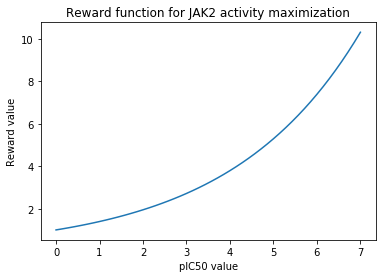

In [13]:
x = np.linspace(0, 7)
y = np.exp(x/3)
plt.plot(x, y)
plt.xlabel('pIC50 value')
plt.ylabel('Reward value')
plt.title('Reward function for JAK2 activity maximization')
plt.show()

In [ ]:
RL_max = Reinforcement(my_generator_max, my_predictor, get_reward_max)

In [ ]:
rewards_max = []
rl_losses_max = []

In [ ]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'): #평균 reward 값 loss 값 IC50 예측 값등이 나옴 
        cur_reward, cur_loss = RL_max.policy_gradient(gen_data, get_features=get_fp)#policy gradient로 reward와 Loss 값 산출 
        rewards_max.append(simple_moving_average(rewards_max, cur_reward)) #reward maximze 하는거 
        rl_losses_max.append(simple_moving_average(rl_losses_max, cur_loss)) #maximize 했을때 loss 값
    
    plt.plot(rewards_max)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses_max)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_max.generator,  #저장한 generator로 생성 
                                                     my_predictor, 
                                                     n_to_generate,
                                                     get_features=get_fp)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

In [ ]:
smiles_biased_max, prediction_biased_max = estimate_and_update(RL_max.generator, 
                                                           my_predictor,
                                                           n_to_generate=5000000)

In [ ]:
import pandas as pd
pd.DataFrame(smiles_biased_max)

In [ ]:
import pandas as pd
rein_smiles=pd.concat([pd.DataFrame(smiles_biased_max),pd.DataFrame(prediction_biased_max)],axis=1)
rein_smiles.columns=["SMILES","pIC50"]

In [ ]:
rein_smiles[rein_smiles.pIC50>=0.5]

In [ ]:
rein_smiles[rein_smiles.pIC50>=0.5].to_csv("data/BBB_rein_1116.csv",index=None)

In [ ]:
#maximized 했을때랑 하지 않았을때의 IC50 값 비교 
sns.kdeplot(prediction_biased_max,label='Maximized', shade=True, color='red')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('pIC50 values')
plt.show()